In [1]:



#  Importing Neccessary Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
)
import shap
import warnings
warnings.filterwarnings('ignore')

# --- Load Dataset ---
df = pd.read_csv("heart.csv")

# --- Preview Data ---
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


## Data inspection 

In [6]:
# --- Data Overview 
print("Dataset Shape:", df.shape)
print("\nColumn Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())


Dataset Shape: (1025, 14)

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB
None

Missing Values:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0


## Exploratory Data Analysis (EDA)

We’ll visualize distributions, correlations, and differences between healthy and heart disease patients.

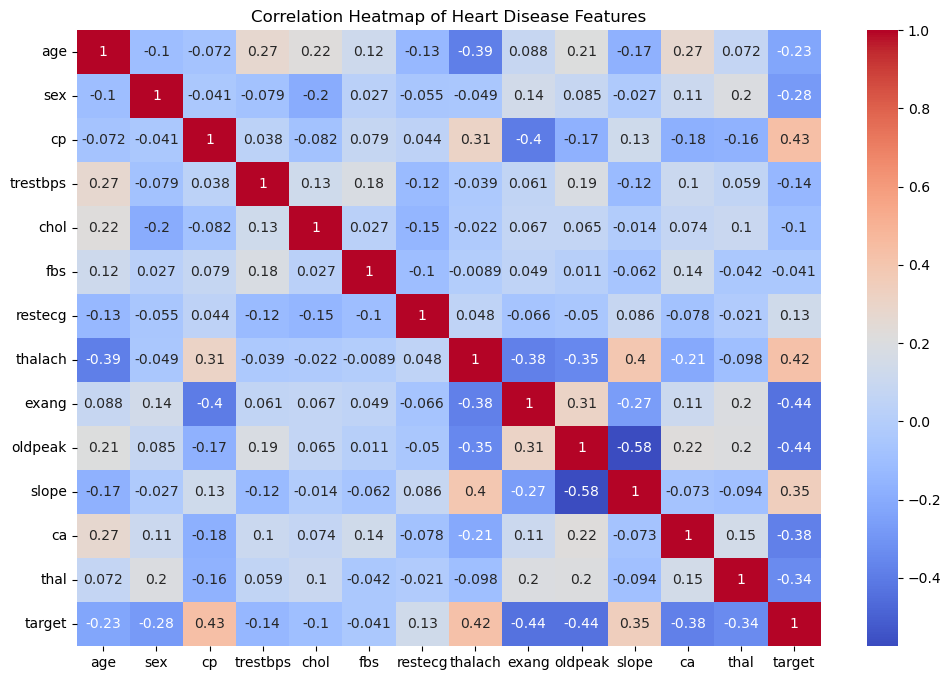

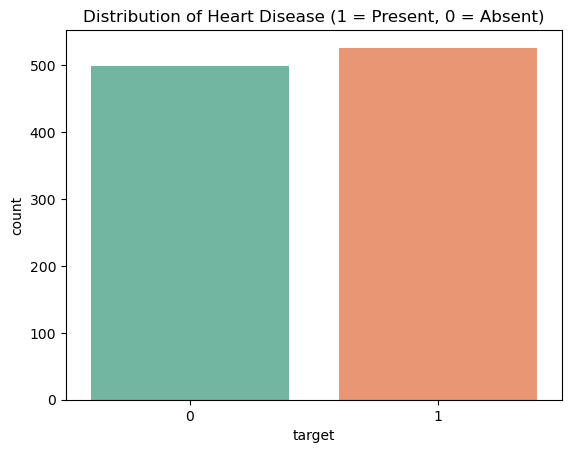

In [7]:
#   Summary Statistics 
df.describe()

#  Correlation Heatmap 
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Heart Disease Features")
plt.show()

#  Target Distribution 
sns.countplot(x='target', data=df, palette='Set2')
plt.title("Distribution of Heart Disease (1 = Present, 0 = Absent)")
plt.show()


## Feature Relationships

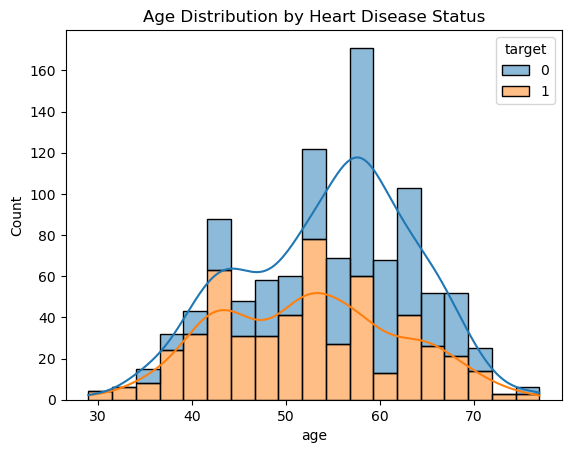

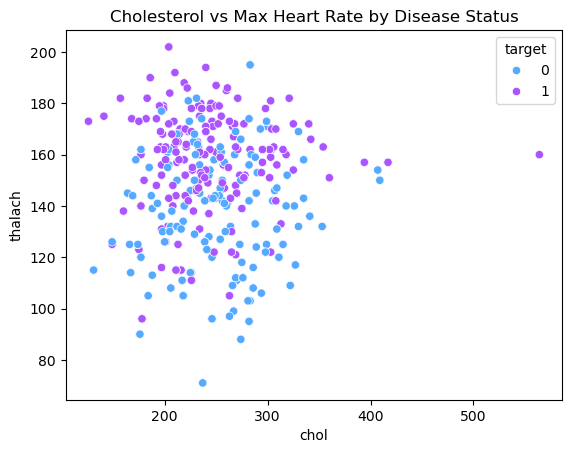

In [10]:
# Age vs Heart Disease
sns.histplot(data=df, x='age', hue='target', kde=True, multiple='stack')
plt.title("Age Distribution by Heart Disease Status")
plt.show()

# Cholesterol and Max Heart Rate
sns.scatterplot(data=df, x='chol', y='thalach', hue='target', palette='cool')
plt.title("Cholesterol vs Max Heart Rate by Disease Status")
plt.show()




## Data preprocessing

In [11]:


#  Define Features and Target
X = df.drop('target', axis=1)
y = df['target']

#  Train-Test Split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#  Scale Features 
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)


## Model building (Random Forest Classifier)

In [12]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

#  Predictions 
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]


## Model evaluation

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



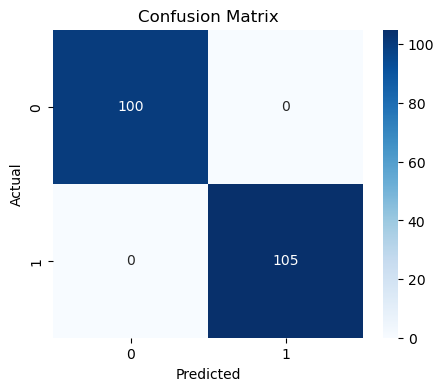

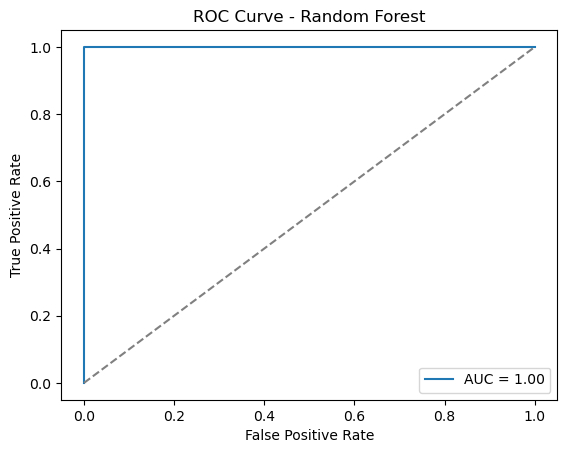

In [13]:
#  Accuracy & Report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()


## Feature Importance

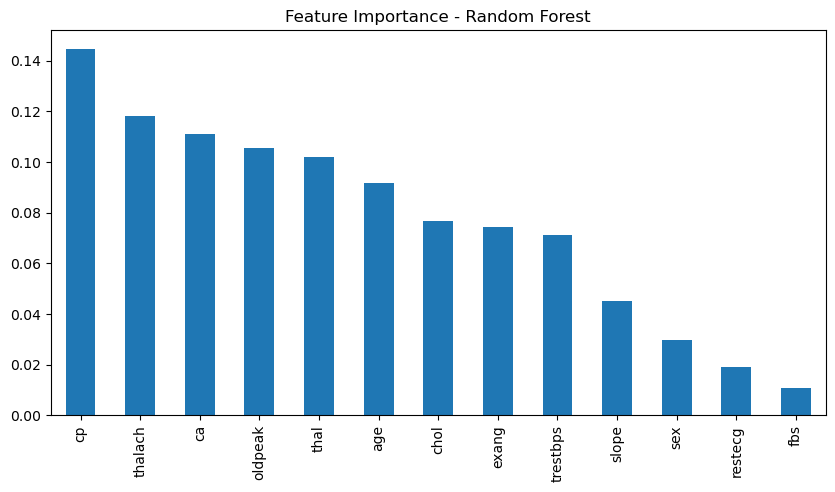

In [14]:
# Feature Importance 
feat_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_importance.plot(kind='bar', figsize=(10,5), title="Feature Importance - Random Forest")
plt.show()


## Model Explainability

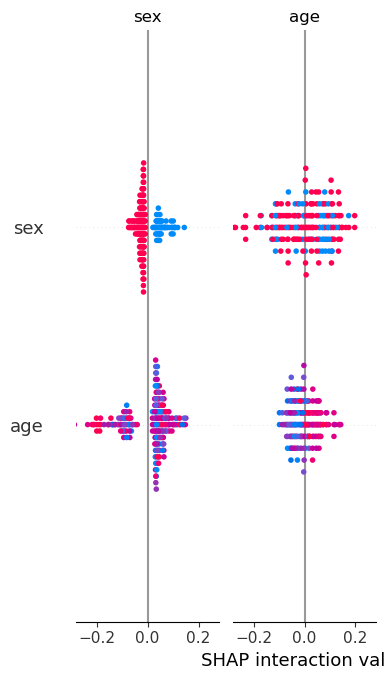

In [22]:
import shap

# Create the explainer and compute SHAP values
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Handle binary vs multiclass safely
if isinstance(shap_values, list):
    shap.summary_plot(shap_values[0], X_test, plot_type="bar")
else:
    shap.summary_plot(shap_values, X_test, plot_type="bar")


### Key Findings

- **Top Risk Factors:** Age, chest pain type, max heart rate (thalach), and ST depression (oldpeak) 
  were most influential in predicting heart disease.
- **Model Performance:** Random Forest achieved high accuracy and ROC-AUC, 
  indicating strong predictive ability.
- **Interpretability (SHAP):**
  - Higher age and cholesterol increase risk.
  - Higher thalach (max heart rate achieved) tends to lower risk.
  - Certain chest pain types strongly indicate presence of heart disease.

### Conclusion

This model can serve as a preliminary screening tool for heart disease risk.  
It should be combined with medical evaluation to support early diagnosis and prevention.
